In [1]:
# Download dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 29.45 MiB/s, done.


In [2]:
# Import necessary libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Perform image augmentation

In [3]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=10,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   validation_split=0.2)

train_data = train_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Training', 
                                               target_size=image_size, 
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               subset='training')

valid_data = train_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Training', 
                                               target_size=image_size, 
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               subset='validation')

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [4]:
train_data.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

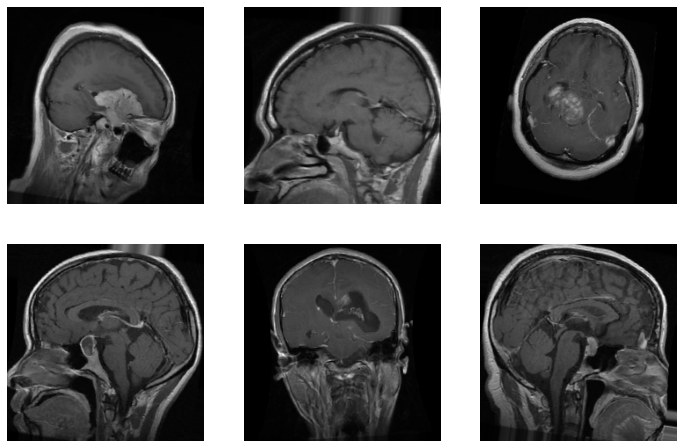

In [5]:
# View 6 samples of the augmented images
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sample = array_to_img(sample_x[i])
    plt.axis('off')
    plt.grid(False)
    plt.imshow(sample)
plt.show()

### Build our CNN model based on EfficientNetB1 model

In [6]:
EffNetB1 = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Rebuild top
model = EffNetB1.output
model = GlobalAveragePooling2D(name='avg_pool')(model)
model = Dropout(0.5, name='top_dropout')(model)
model = Dense(4, activation='softmax', name='predict')(model)

model = Model(inputs=EffNetB1.input, outputs=model, name='EfficientNet')

model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________

In [7]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

In [8]:
train_history = model.fit(train_data, epochs=10, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
72/72 [==============================] - 72s 630ms/step - loss: 0.7417 - accuracy: 0.7209 - val_loss: 0.9074 - val_accuracy: 0.6091

Epoch 00001: val_accuracy improved from -inf to 0.60908, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
72/72 [==============================] - 43s 601ms/step - loss: 0.2917 - accuracy: 0.9007 - val_loss: 0.5379 - val_accuracy: 0.7923

Epoch 00002: val_accuracy improved from 0.60908 to 0.79232, saving model to model.h5
Epoch 3/10
72/72 [==============================] - 43s 599ms/step - loss: 0.1653 - accuracy: 0.9495 - val_loss: 0.5166 - val_accuracy: 0.8028

Epoch 00003: val_accuracy improved from 0.79232 to 0.80279, saving model to model.h5
Epoch 4/10
72/72 [==============================] - 43s 598ms/step - loss: 0.1122 - accuracy: 0.9669 - val_loss: 0.4554 - val_accuracy: 0.8377

Epoch 00004: val_accuracy improved from 0.80279 to 0.83770, saving model to model.h5
Epoch 5/10
72/72 [==============================] - 43s 598ms/step - loss: 0.0870 - accuracy: 0.9747 - val_loss: 0.6345 - val_accuracy: 0.7696

Epoch 00005: val_accuracy did not improve from 0.83770
Epoch 6/10
72/72 [==============================] - 43s 599ms/step - loss: 0.0654 - accuracy: 0.9743 - val_loss: 0

The train accuracy is 99.22% and the validation accuracy is 90.75%.

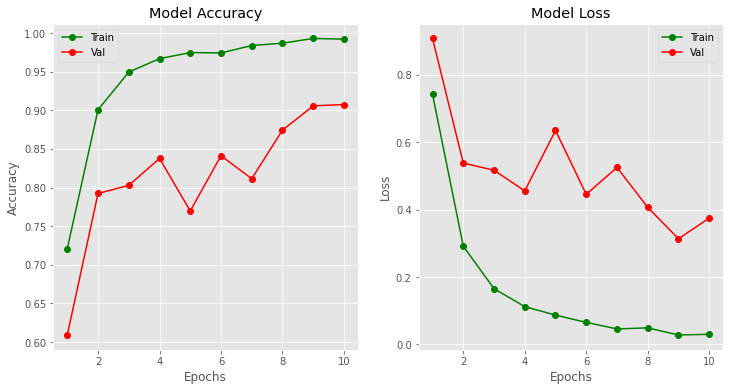

In [9]:
# Plot the training curves
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
epochs = range(1,11)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_history.history['accuracy'], 'go-')
plt.plot(epochs, train_history.history['val_accuracy'], 'ro-')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_history.history['loss'], 'go-')
plt.plot(epochs, train_history.history['val_loss'], 'ro-')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Evaluate model performance on the test dataset

In [10]:
test_datagen = ImageDataGenerator()
test_data = test_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Testing', 
                                             target_size=image_size, 
                                             class_mode='categorical')

Found 394 images belonging to 4 classes.


In [11]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 2s - loss: 1.3272 - accuracy: 0.7259
Test accuracy is 72.59%


The test accuracy is 72.59%.  Comparing to the 71.83% test accuracy of the original model, there is not much improvement.

### Unfreeze top 30 layers of Efficient Net model

In [12]:
for layer in model.layers[-30:]:
  if not isinstance(layer, BatchNormalization):
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
train_history = model.fit(train_data, epochs=10, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
72/72 [==============================] - 55s 629ms/step - loss: 0.0214 - accuracy: 0.9939 - val_loss: 0.3051 - val_accuracy: 0.9005

Epoch 00001: val_accuracy did not improve from 0.90750
Epoch 2/10
72/72 [==============================] - 43s 600ms/step - loss: 0.0324 - accuracy: 0.9896 - val_loss: 0.3212 - val_accuracy: 0.9145

Epoch 00002: val_accuracy improved from 0.90750 to 0.91449, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10
72/72 [==============================] - 43s 601ms/step - loss: 0.0433 - accuracy: 0.9861 - val_loss: 0.2866 - val_accuracy: 0.9250

Epoch 00003: val_accuracy improved from 0.91449 to 0.92496, saving model to model.h5
Epoch 4/10
72/72 [==============================] - 43s 599ms/step - loss: 0.0168 - accuracy: 0.9952 - val_loss: 0.1395 - val_accuracy: 0.9581

Epoch 00004: val_accuracy improved from 0.92496 to 0.95812, saving model to model.h5
Epoch 5/10
72/72 [==============================] - 43s 599ms/step - loss: 0.0226 - accuracy: 0.9926 - val_loss: 0.2998 - val_accuracy: 0.9319

Epoch 00005: val_accuracy did not improve from 0.95812
Epoch 6/10
72/72 [==============================] - 43s 600ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 0.2366 - val_accuracy: 0.9529

Epoch 00006: val_accuracy did not improve from 0.95812
Epoch 7/10
72/72 [==============================] - 43s 597ms/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 0.2059 - val_accuracy: 0.9442



In [13]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 1s - loss: 1.2525 - accuracy: 0.8046
Test accuracy is 80.46%


Unfreezing the top 30 layers helps to boost up the test accuracy from 72.59% to 80.46% which is about 10.8%.  Comparing to the original model with a 71.83% test accuracy, there is a 12% improvement.

### Model evaluation

In [14]:
# Get the labels
predictions = np.array([])
true_labels = np.array([])

for batch in range(len(test_data)):
    x, y = test_data[batch]
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    true_labels = np.concatenate([true_labels, np.argmax(y, axis=1)])

# Look at the first 10 predictions and labels
print('predictions = ', predictions[:10])
print('True labels = ', true_labels[:10])

predictions =  [1. 1. 2. 1. 1. 3. 1. 1. 2. 2.]
True labels =  [1. 1. 2. 1. 1. 3. 0. 1. 1. 2.]


In [15]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[ 36  43  19   2]
 [  0 114   1   0]
 [  0   0 105   0]
 [  0   6   6  62]], shape=(4, 4), dtype=int32)


In [16]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_labels, predictions, target_names=test_data.class_indices.keys()))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.36      0.53       100
meningioma_tumor       0.70      0.99      0.82       115
        no_tumor       0.80      1.00      0.89       105
 pituitary_tumor       0.97      0.84      0.90        74

        accuracy                           0.80       394
       macro avg       0.87      0.80      0.78       394
    weighted avg       0.85      0.80      0.78       394



The recall rate of the glioma tumor class of the original model was very low.  We see that there is an improvement using the transfer learning technique.  The recall rate goes up from 0.18 to 0.36.  The meningioma tumor and no tumor classes also improved in recall rates.  However, the recall rate of the pituitary tumor class goes down from 0.95 to 0.84.  